Pick up where I left off...

# Data

Previous modeling effort processed data in notebook `b_/00c`, saved each market's data as a pickle file. Then, when it came time to EDA, modeling -- just read in a .pkl file

Now, the processing code in notebook `00c` is captured by script `preprocess.py`. So we just need to load that data, filter by market, and save a pickle file.

Do this using a script

In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import datetime

from sklearn.model_selection import train_test_split

In [2]:
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 100)

## load and inspect

In [5]:
DATA_DIR = "/data/16/kendra.frederick/shopping_grid/output/market_pkl_files_take2/"

In [5]:
!ls $DATA_DIR

ATL-EWR.pkl  EWR-CDG.pkl  EWR-MIA.pkl  JFK-MIA.pkl  LGA-MIA.pkl  OAK-LAS.pkl
ATL-LAS.pkl  EWR-FLL.pkl  JFK-LAX.pkl  LAX-EWR.pkl  LHR-EWR.pkl  SFO-LAX.pkl
AUS-DEN.pkl  EWR-LAX.pkl  JFK-LGW.pkl  LAX-JFK.pkl  LHR-JFK.pkl
DFW-ORD.pkl  EWR-LHR.pkl  JFK-LHR.pkl  LAX-SFO.pkl  LHR-LAX.pkl


In [6]:
market = "EWR-MIA"
filename = "{}.pkl".format(market)
df = pd.read_pickle(os.path.join(DATA_DIR, filename))

In [7]:
len(df)

134173

## helper funcs

In [8]:
def plot_min_fare(market_pdf, dd, rd, market):
    trip_df = market_pdf[(market_pdf['outDeptDt'] == dd) & (market_pdf['inDeptDt'] == rd)]
    trip_df.sort_values(by='searchDt_dt', inplace=True)
    plt.figure(figsize=(12,5))
    plt.plot(-trip_df['days_til_dept'], trip_df['min_fare'], marker='o')
    plt.xlabel("advanced purchase days")
    plt.ylabel('min fare (USD)')
    plt.title(f"{market} - depart {dd} - return {rd}");

# train-test split 

prior to EDA

In [9]:
target_col = 'min_fare'
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=19)
train_pdf = pd.concat([X_train, y_train], axis=1)
train_pdf["train_test"] = "train"
X_test["train_test"] = "test"
mask_df = pd.concat([train_pdf, X_test], axis=0, sort=False)

# RT vs OW

In [10]:
df_rt = mask_df[mask_df['round_trip'] == 1].dropna(subset=[target_col])
df_ow = mask_df[mask_df['round_trip'] == 0].dropna(subset=[target_col])

In [11]:
len(df_rt), len(df_ow)

(112584, 8171)

## RT

In [12]:
data = df_rt['min_fare']

In [13]:
df_rt['min_fare'].describe()

count    112584.000000
mean        181.966868
std         125.940774
min          40.920000
25%          97.200000
50%         140.180000
75%         216.170000
max        2031.690000
Name: min_fare, dtype: float64

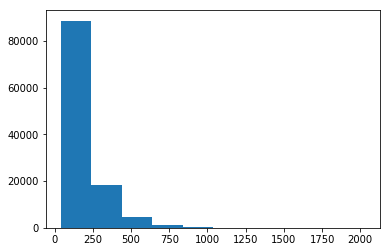

In [14]:
plt.hist(df_rt['min_fare']);

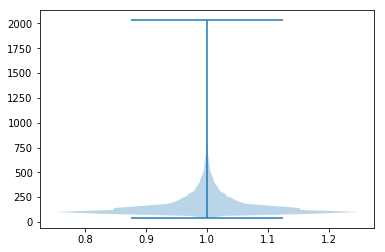

In [15]:
plt.violinplot(df_rt['min_fare']);

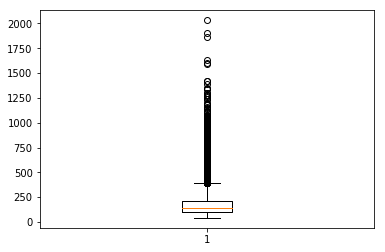

In [16]:
plt.boxplot(df_rt['min_fare']);

In [17]:
# # filter out anomalously high/low fares
# count_llim = data_params['count_llim']
# fare_ulim = np.percentile(data, market_configs["fare_ulim_percentile"])
# fare_llim = np.percentile(market_pdf[target_col], market_configs["fare_llim_percentile"])

for q in [0.1, 1, 5, 50, 95, 99, 99.9]:
    print(f"{q}%: {np.percentile(data, q)}")

0.1%: 73.19
1%: 73.19
5%: 85.19
50%: 140.18
95%: 445.2
99%: 665.2
99.9%: 945.2425000000396


In [18]:
print("Lower q, value, num data less than")
for q in [0.1, 0.25, 0.5]:
    llim = np.percentile(data, q)
    toss_data = data[data <= llim]
    clipped_data = data[data>llim]
    print(f"{q}%, {llim:.0f}, {len(toss_data)}")

Lower q, value, num data less than
0.1%, 73, 3309
0.25%, 73, 3309
0.5%, 73, 3309


In [19]:
print("Upper q, value, num data greater than")
for q in [99, 99.5, 99.75, 99.9]:
    ulim = np.percentile(data, q)
    toss_data = data[data >= ulim]
    clipped_data = data[data < ulim]
    print(f"{q}%, {ulim:.0f}, {len(toss_data)}")

Upper q, value, num data greater than
99%, 665, 1129
99.5%, 759, 599
99.75%, 843, 288
99.9%, 945, 113


In [20]:
lq = 0.25
uq = 99.75

llim = np.percentile(data, lq)
ulim = np.percentile(data, uq)

clip_rt_df = df_rt[df_rt['min_fare'].between(llim, ulim)]
len(clip_rt_df) / len(df_rt)

0.9974952035813259

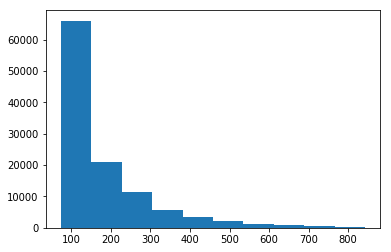

In [21]:
plt.hist(clip_rt_df['min_fare']);

Not a normal distribution, but less skewed than before

ALT: use multiple of median instead of percentiles

## OW

In [22]:
df_ow['min_fare'].describe()

count    8171.000000
mean       59.631782
std        29.870076
min        36.590000
25%        48.590000
50%        48.600000
75%        72.590000
max       379.580000
Name: min_fare, dtype: float64

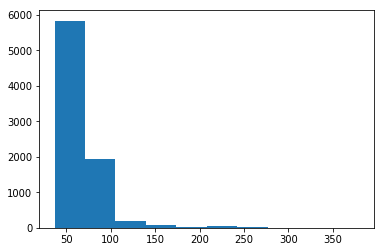

In [23]:
plt.hist(df_ow['min_fare']);

More normally distributed than RT fares

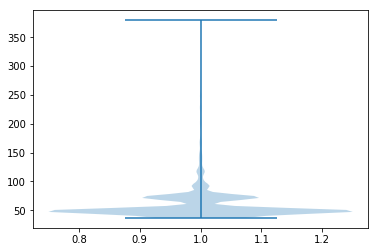

In [24]:
plt.violinplot(df_ow['min_fare']);

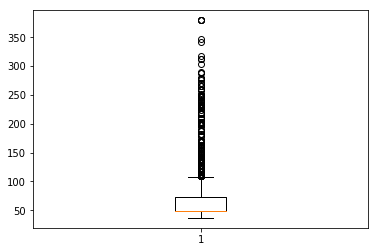

In [25]:
plt.boxplot(df_ow['min_fare']);

In [26]:
data = df_ow['min_fare']

In [27]:
for q in [0.1, 1, 5, 50, 95, 99, 99.9]:
    print(f"{q}%: {np.percentile(data, q)}")

0.1%: 36.59
1%: 36.59
5%: 36.59
50%: 48.6
95%: 102.85
99%: 209.58
99.9%: 310.6467000000071


In [75]:
print("Lower q, value, num data less than")
for q in [0.1, 0.25, 0.5, 1]:
    llim = np.percentile(data, q)
    toss_data = data[data <= llim]
    clipped_data = data[data>llim]
    print(f"{q}%, {llim:.0f}, {len(toss_data)}")

Lower q, value, num data less than
0.1%, 37, 995
0.25%, 37, 995
0.5%, 37, 995
1%, 37, 995


In [76]:
print("Upper q, value, num data greater than")
for q in [99, 99.5, 99.75, 99.9, 99.99]:
    ulim = np.percentile(data, q)
    toss_data = data[data >= ulim]
    clipped_data = data[data < ulim]
    print(f"{q}%, {ulim:.0f}, {len(toss_data)}")

Upper q, value, num data greater than
99%, 210, 89
99.5%, 247, 41
99.75%, 266, 22
99.9%, 311, 9
99.99%, 380, 4


In [77]:
data = df_ow['min_fare']
lq = 0
uq = 99.95

llim = np.percentile(data, lq)
ulim = np.percentile(data, uq)

clip_ow_df = df_ow[df_ow['min_fare'].between(llim, ulim)]
len(clip_ow_df) / len(df_ow)

0.9993880797943948

# EDA
focusing on OW. Less data, but more "well-behaved"

## by dtd

In [78]:
dtd_grp = clip_ow_df.groupby('days_til_dept').agg(
    {'min_fare': ['mean', 'std', np.median]}
)

dtd_grp.columns = ['avg_min_fare', 'std_min_fare', 'median_min_fare']
dtd_grp.reset_index(inplace=True)

dtd_grp.sort_values(by='days_til_dept', inplace=True)

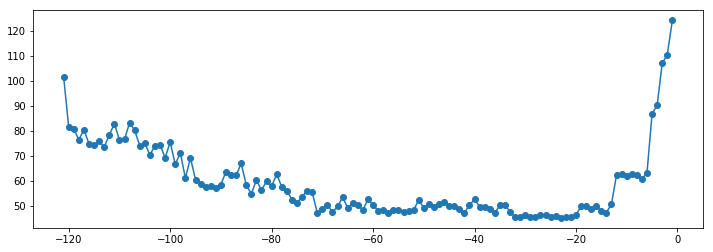

In [79]:
plt.figure(figsize=(12, 4))
plt.plot(-dtd_grp['days_til_dept'], dtd_grp['avg_min_fare'], marker='o');

Interesting -- a nice steady increase in fare

In [80]:
dtd_grp.head(21)

,days_til_dept,avg_min_fare,std_min_fare,median_min_fare
0,1,124.342167,38.688550,117.59
1,2,110.581884,28.855584,102.59
2,3,107.057917,25.748423,102.59
3,4,90.266765,10.600504,91.59
4,5,86.899706,12.423400,91.59
5,6,63.248429,13.237865,72.59
6,7,60.683846,12.214955,63.60
7,8,62.278358,11.954417,68.60
8,9,62.935075,11.563306,72.59
9,10,62.061364,11.606680,68.60


In [81]:
# try being super-conservative? (x=30) or permissive? (x=3 or 7)
dtd_cutoff = 7
clip_ow_df['dtd_regime'] = np.where(clip_ow_df['days_til_dept'] < dtd_cutoff, 'close_to_dept', 'farther_out')
far_out_df = clip_ow_df[clip_ow_df['dtd_regime'] == 'farther_out']

## by DOW

In [82]:
dow_list =  ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
dow_dict = dict(zip(range(7), dow_list))

def extract_dow(df, ow=False):
    df['dept_dt_dow_int'] = df['outDeptDt_dt'].apply(
            lambda d: datetime.date.weekday(d))
    df['dept_dt_dow'] = df['dept_dt_dow_int'].map(
        dow_dict)
    if not ow:
        df['return_dt_dow'] = df['inDeptDt_dt'].apply(
                lambda d: datetime.date.weekday(d))
    return df

# def extract_dow_type(df, dow_int_col):
#     new_col = dow_int_col.replace('_int', '_type')
#     print(new_col)
#     df[new_col] = np.where(df[dow_int_col].isin([4,5]), 'weekend', 
#                            np.where(df[dow_int_col].isin([3,6]), 'shoulder', 'weekday')
#                           )
#     return df

In [83]:
far_out_df = extract_dow(far_out_df, ow=True)

In [84]:
# dow_summ = mask_df.groupby(["dept_dt_dow"])["min_fare"].mean()
dow_summ = far_out_df.groupby(["dept_dt_dow"]).agg(
    {"min_fare": ['mean', 'std', np.median]}
)
dow_summ = pd.DataFrame(dow_summ)

dow_summ.columns = ['avg_min_fare', 'std_min_fare', 'median_min_fare']

dow_summ.reset_index(inplace=True)

dow_summ['dow_int'] = dow_summ['dept_dt_dow'].apply(lambda x: dow_list.index(x))

dow_summ.sort_values(by='dow_int', inplace=True)

In [85]:
dow_summ

,dept_dt_dow,avg_min_fare,std_min_fare,median_min_fare,dow_int
1,Mon,58.487011,24.554081,48.60,0
5,Tue,52.813651,24.815390,48.59,1
6,Wed,53.606974,22.932021,48.59,2
4,Thu,61.190722,25.834988,48.60,3
0,Fri,64.819359,34.346712,48.60,4
2,Sat,58.492278,33.100199,48.60,5
3,Sun,60.252105,24.970083,48.60,6


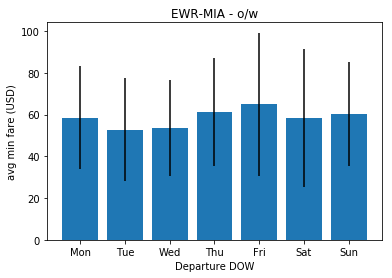

In [86]:
xs = range(7)
plt.bar(xs, dow_summ['avg_min_fare'], yerr=dow_summ['std_min_fare'])
plt.xticks(xs, dow_list);
plt.ylabel("avg min fare (USD)")
plt.xlabel("Departure DOW")
plt.title(f"{market} - o/w");

Pretty consistent across DOW

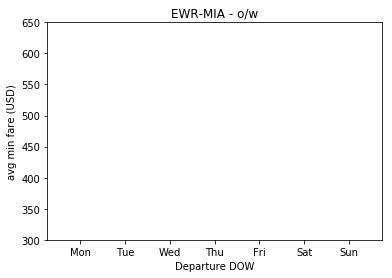

In [87]:
xs = range(7)
plt.bar(xs, dow_summ['avg_min_fare'], yerr=dow_summ['std_min_fare'])
plt.xticks(xs, dow_list);
plt.ylabel("avg min fare (USD)")
plt.xlabel("Departure DOW")
plt.ylim(300, 650)
plt.title(f"{market} - o/w");

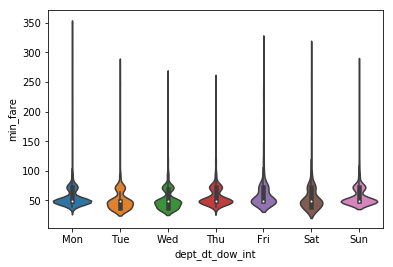

In [88]:
sns.violinplot(data=far_out_df, x='dept_dt_dow_int', y='min_fare');
plt.xticks(range(7), dow_list);

# EDA on +/- 1 dept day

Actually, let's just look back for "prev dept day", regardless of "dow type", and use that info to inform how we define "dow type"

In [89]:
eda_shifted_features_dict = {
    # shift search day -1
    "min_fare_prev_search_day": {
        'sort_col': 'searchDt',
        'groupby_cols': ['outDeptDt', 'inDeptDt']
    },
    # shift departure day +/- 1
    "min_fare_prev_dept_day": {
        'sort_col': 'outDeptDt',
        'groupby_cols': ['searchDt']
    },
    "min_fare_next_dept_day": {
        'sort_col': 'outDeptDt',
        'groupby_cols': ['searchDt'],
        'shift': -1
    },
}

for feature_name, kwargs in eda_shifted_features_dict.items():
    far_out_df[feature_name] = (far_out_df
                    .sort_values(by=kwargs['sort_col'])
                    .groupby(kwargs['groupby_cols'])[target_col]
                    .shift(kwargs.get("shift", 1)) 
                )

dow_shifted_features_dict = {
    # shift departure day +/- 1
    "prev_dept_dow": {
        'sort_col': 'outDeptDt',
        'groupby_cols': ['searchDt']
    },
    "next_dept_dow": {
        'sort_col': 'outDeptDt',
        'groupby_cols': ['searchDt'],
        'shift': -1
    },
}

for feature_name, kwargs in dow_shifted_features_dict.items():
    far_out_df[feature_name] = (far_out_df
                    .sort_values(by=kwargs['sort_col'])
                    .groupby(kwargs['groupby_cols'])['dept_dt_dow']
                    .shift(kwargs.get("shift", 1)) 
                )


dow_shifted_features_dict = {
    # shift departure day +/- 1
    "prev_dept_dow_int": {
        'sort_col': 'outDeptDt',
        'groupby_cols': ['searchDt']
    },
    "next_dept_dow_int": {
        'sort_col': 'outDeptDt',
        'groupby_cols': ['searchDt'],
        'shift': -1
    },
}

for feature_name, kwargs in dow_shifted_features_dict.items():
    far_out_df[feature_name] = (far_out_df
                    .sort_values(by=kwargs['sort_col'])
                    .groupby(kwargs['groupby_cols'])['dept_dt_dow_int']
                    .shift(kwargs.get("shift", 1)) 
                )

In [90]:
far_out_df.head()

,market,origin,destination,round_trip,pos,currency,outDeptDt,inDeptDt,shop_counts,origin_country,origin_city,destination_country,destination_city,outDeptDt_dt,inDeptDt_dt,searchDt_dt,days_til_dept,stay_duration,shop_ind,searchDt,min_fare,train_test,dtd_regime,dept_dt_dow_int,dept_dt_dow,min_fare_prev_search_day,min_fare_prev_dept_day,min_fare_next_dept_day,prev_dept_dow,next_dept_dow,prev_dept_dow_int,next_dept_dow_int
498777,EWR-MIA,EWR,MIA,0,US,USD,20230113,0,87,US,EWR,US,MIA,2023-01-13,None,2022-09-15,120,NaN,1,20220915,72.59,train,farther_out,4,Fri,198.60,157.60,91.60,Thu,Sat,3.0,5.0
80349,EWR-MIA,EWR,MIA,0,US,USD,20221218,0,758,US,EWR,US,MIA,2022-12-18,None,2022-10-25,54,NaN,1,20221025,48.59,train,farther_out,6,Sun,48.59,36.59,48.59,Sat,Mon,5.0,0.0
1040607,EWR-MIA,EWR,MIA,0,US,USD,20221213,0,79,US,EWR,US,MIA,2022-12-13,None,2022-09-01,103,NaN,1,20220901,48.60,train,farther_out,1,Tue,48.60,48.60,48.60,Mon,Wed,0.0,2.0
434494,EWR-MIA,EWR,MIA,0,US,USD,20221103,0,453,US,EWR,US,MIA,2022-11-03,None,2022-08-31,64,NaN,1,20220831,48.60,train,farther_out,3,Thu,38.60,38.60,102.59,Wed,Fri,2.0,4.0
62626,EWR-MIA,EWR,MIA,0,US,USD,20221107,0,2073,US,EWR,US,MIA,2022-11-07,None,2022-11-04,3,NaN,1,20221104,135.91,train,farther_out,0,Mon,91.59,NaN,91.59,NaN,Tue,NaN,1.0


In [91]:
ex_df = far_out_df[far_out_df['searchDt'] == 20221101]
ex_df.sort_values(by='outDeptDt_dt', inplace=True)
ex_df[['outDeptDt_dt', 'dept_dt_dow', 'min_fare', 
       'prev_dept_dow', 'min_fare_prev_dept_day', ]].head(15)

,outDeptDt_dt,dept_dt_dow,min_fare,prev_dept_dow,min_fare_prev_dept_day
1223352,2022-11-04,Fri,145.91,NaN,NaN
1225358,2022-11-05,Sat,86.58,Fri,145.91
1224065,2022-11-06,Sun,91.59,Sat,86.58
1223120,2022-11-07,Mon,48.59,Sun,91.59
1223184,2022-11-08,Tue,48.59,Mon,48.59
1223337,2022-11-09,Wed,48.59,Tue,48.59
1223723,2022-11-10,Thu,48.59,Wed,48.59
1223867,2022-11-11,Fri,48.59,Thu,48.59
1225085,2022-11-13,Sun,48.59,Fri,48.59
1223175,2022-11-14,Mon,48.59,Sun,48.59


In [92]:
comp_col = 'min_fare_prev_search_day'
df_no_null = far_out_df.dropna(subset=['min_fare', comp_col])
np.corrcoef(df_no_null['min_fare'], df_no_null[comp_col])

array([[1.        , 0.46448583],
       [0.46448583, 1.        ]])

Poor correlation here

In [93]:
comp_col = 'min_fare_prev_dept_day'
df_no_null = far_out_df.dropna(subset=['min_fare', comp_col])
np.corrcoef(df_no_null['min_fare'], df_no_null[comp_col])

array([[1.        , 0.44275742],
       [0.44275742, 1.        ]])

Also for this

In [94]:
far_out_df['fare_diff_prev_shop_dt'] = far_out_df['min_fare'] - far_out_df['min_fare_prev_search_day']
far_out_df['fare_diff_prev_dept_dt'] = far_out_df['min_fare'] - far_out_df['min_fare_prev_dept_day']

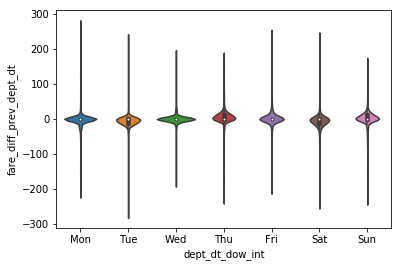

In [95]:
sns.violinplot(data=far_out_df, x='dept_dt_dow_int', y='fare_diff_prev_dept_dt');
plt.xticks(range(7), dow_list);

In [96]:
# not_close_df = mask_df[np.abs(mask_df['fare_diff_prev_dept_dt']) > 50]
# close_df = mask_df[np.abs(mask_df['fare_diff_prev_dept_dt']) <20]

# len(not_close_df), len(close_df)

## plots of individual trips

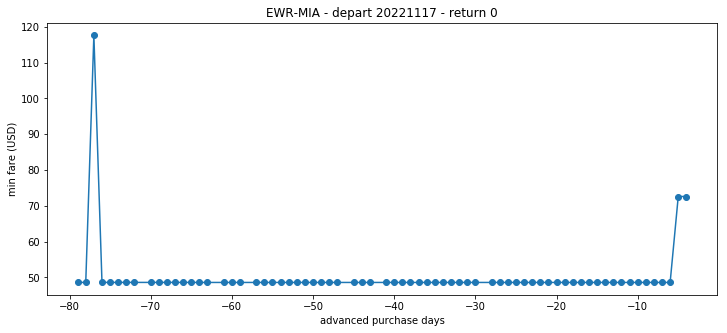

In [97]:
plot_min_fare(far_out_df, 20221117, 0, market)

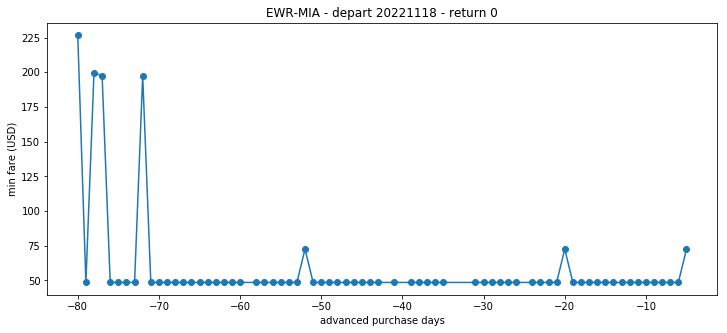

In [98]:
plot_min_fare(far_out_df, 20221118, 0, market)

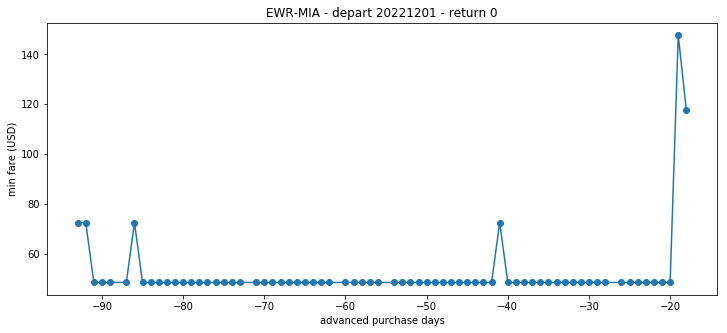

In [99]:
plot_min_fare(far_out_df, 20221201, 0, market)

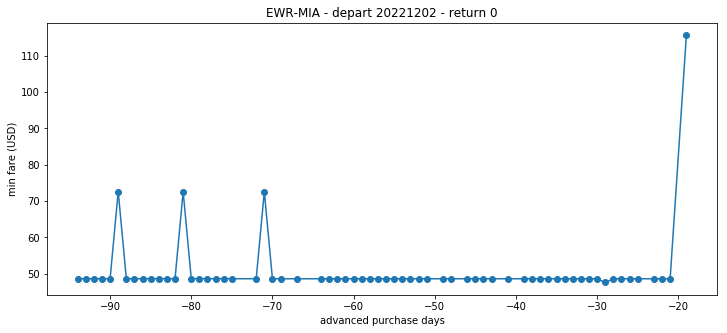

In [100]:
plot_min_fare(far_out_df, 20221202, 0, market)

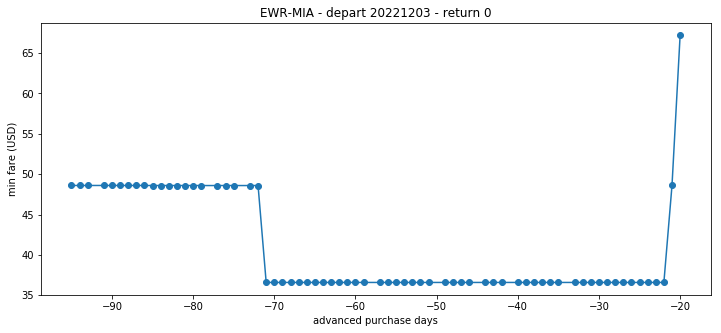

In [101]:
plot_min_fare(far_out_df, 20221203, 0, market)

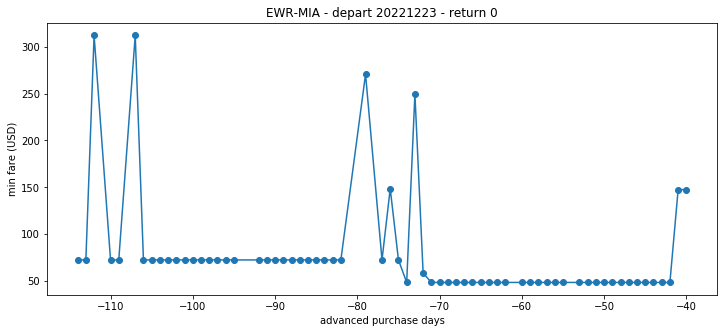

In [102]:
plot_min_fare(far_out_df, 20221223, 0, market)

This market is probably: "Is Frontier / Spirit available? If not, Delta & fare is $$$"

## heatmaps

### fares

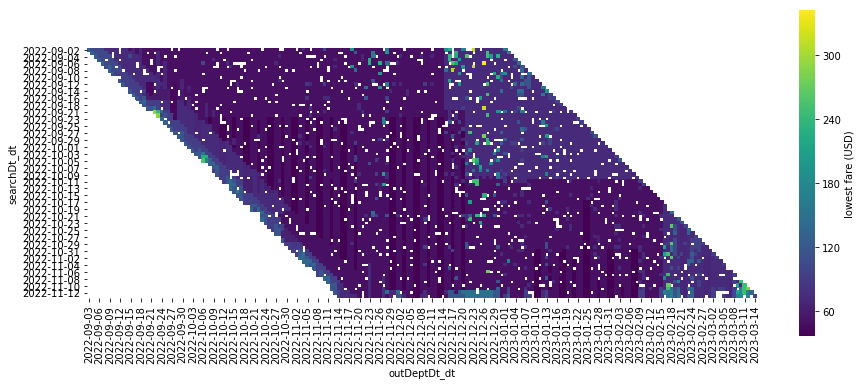

In [103]:
# data *not* filtered by dtd regime
clip_for_plot = clip_ow_df[(clip_ow_df['outDeptDt_dt'] > datetime.date(2022,9,1))
                       &(clip_ow_df['searchDt_dt'] > datetime.date(2022,9,1))]

plt.figure(figsize=(15,12))
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="min_fare")
sns.heatmap(pvt_data, cmap='viridis', square=True,
                cbar_kws={'label': 'lowest fare (USD)',
                            'shrink': 0.5,
                            }
                );

### vs. previous shop day

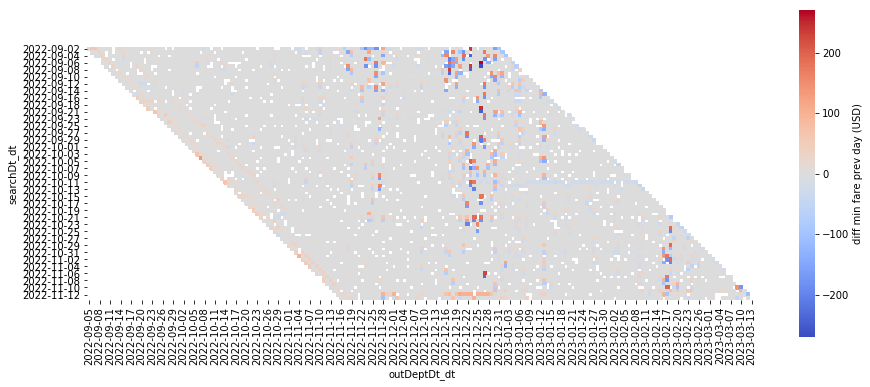

In [104]:
# don't include close-to-departure-date data
clip_for_plot = far_out_df[(far_out_df['outDeptDt_dt'] > datetime.date(2022,9,1))
                       &(far_out_df['searchDt_dt'] > datetime.date(2022,9,1))]
plt.figure(figsize=(15,12))
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_shop_dt")
sns.heatmap(pvt_data, cmap='coolwarm', square=True,
                cbar_kws={'label': 'diff min fare prev day (USD)',
                            'shrink': 0.5,
                            }
                );

Holiday fares appear to be less volatile

Boolean: are fares close or not?

In [105]:
far_out_df['fare_prev_shop_dt_close'] = np.where(
    np.isclose(far_out_df['min_fare'], far_out_df['min_fare_prev_search_day'], 0.01), 1, 0)

comp_df = far_out_df.dropna(subset=['min_fare', 'min_fare_prev_search_day'])

In [106]:
comp_df['fare_prev_shop_dt_close'].value_counts(1)

1    0.835522
0    0.164478
Name: fare_prev_shop_dt_close, dtype: float64

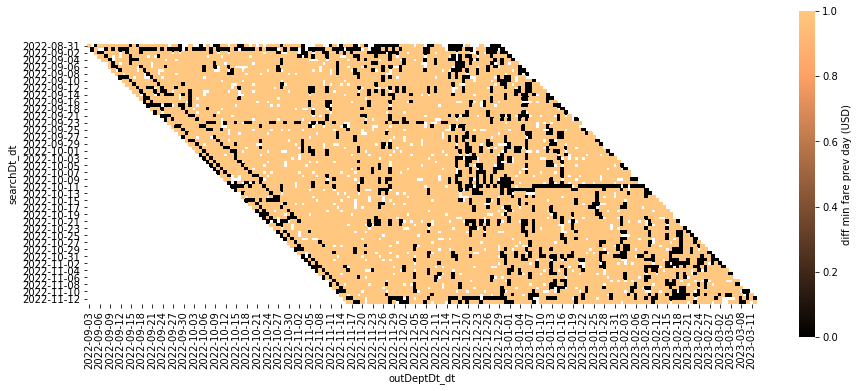

In [107]:
# clip_for_plot = mask_df[(mask_df['outDeptDt_dt'] > datetime.date(2022,9,1))
#                        &(mask_df['searchDt_dt'] > datetime.date(2022,9,1))]
plt.figure(figsize=(15,12))
pvt_data = comp_df.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_prev_shop_dt_close")

sns.heatmap(pvt_data, cmap='copper', square=True,
                cbar_kws={'label': 'diff min fare prev day (USD)',
                            'shrink': 0.5,
                            }
                );

### vs prev dept day

In [108]:
# computed above:
# mask_df['fare_diff_prev_dept_dt'] = mask_df['min_fare'] - mask_df['min_fare_prev_dept_day']

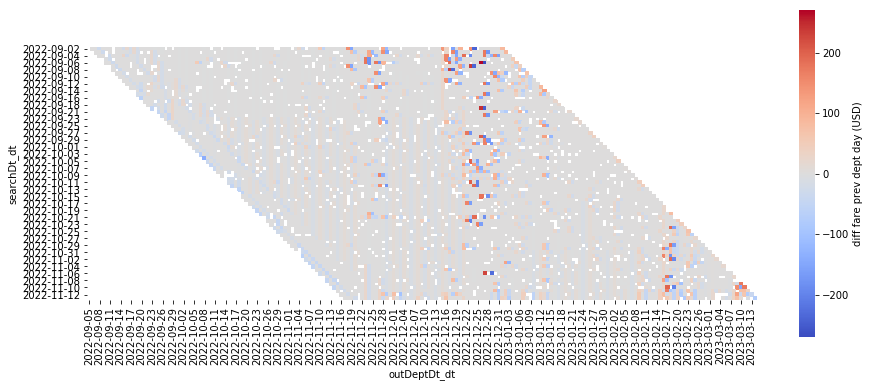

In [109]:
clip_for_plot = far_out_df[(far_out_df['outDeptDt_dt'] > datetime.date(2022,9,1))
                       &(far_out_df['searchDt_dt'] > datetime.date(2022,9,1))]
plt.figure(figsize=(15,12))
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
sns.heatmap(pvt_data, cmap='coolwarm', square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,
                            }
                );

#### Examine by DOW

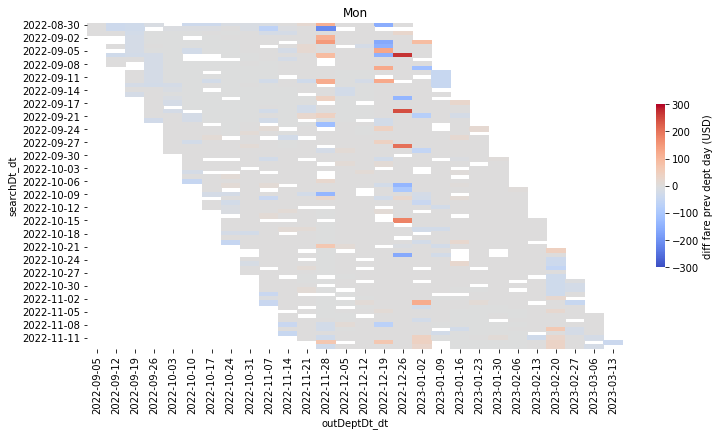

In [110]:
dow = "Mon"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

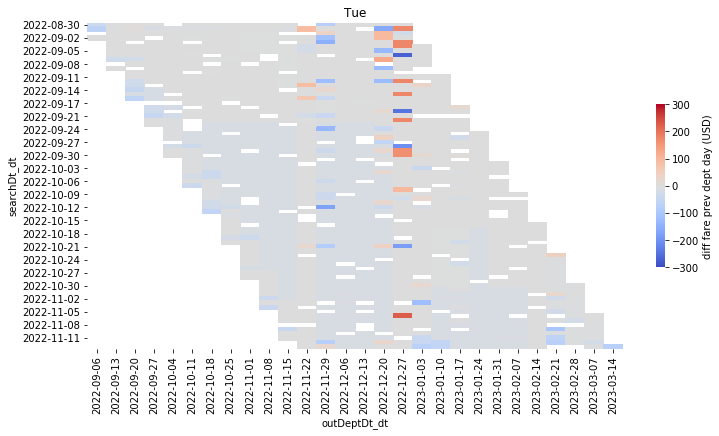

In [111]:
dow = "Tue"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

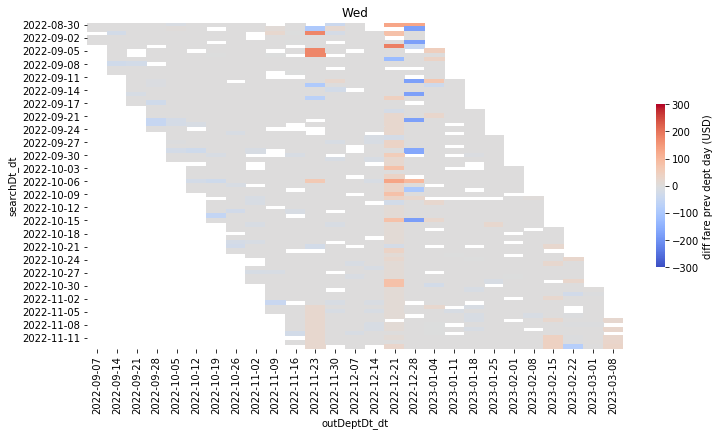

In [112]:
dow = "Wed"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

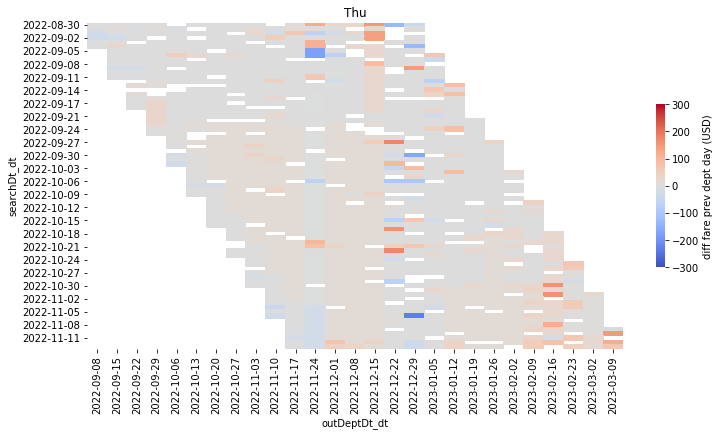

In [113]:
dow = "Thu"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

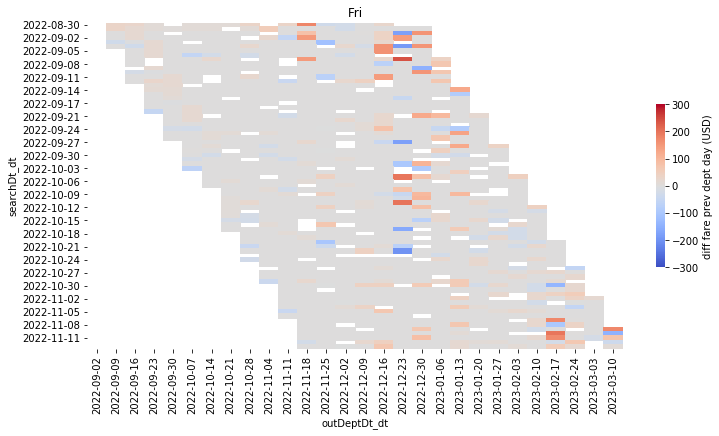

In [114]:
dow = "Fri"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

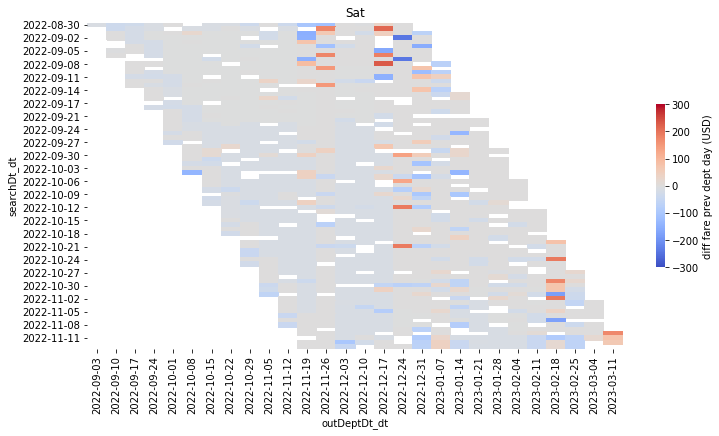

In [115]:
dow = "Sat"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

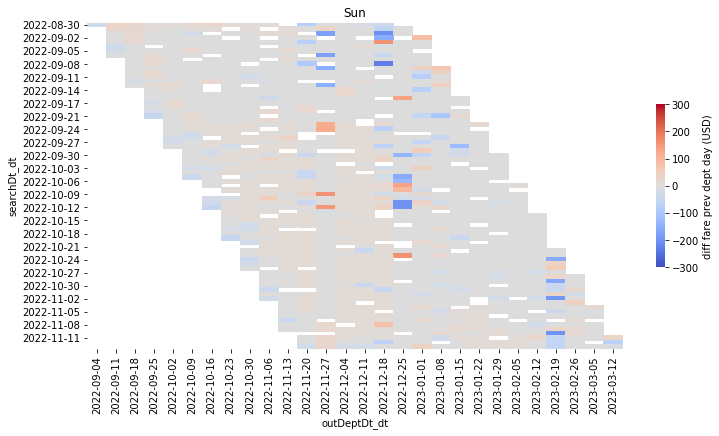

In [116]:
dow = "Sun"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

### conclusion (?)

For some DOW's, the difference between prev dept day appears to be consistent across a departure day
- so: feature(s) we should engineer & pull forward is/are: 
    - prev fare diff + prev day fare
    - median prev fare diff (last 3 days) + median prev day fare (last 3 days)

In [117]:
far_out_df['shifted_fare_diff_prev_dd'] = (far_out_df
                                        .sort_values(by=['searchDt'])
                                        .groupby(['outDeptDt'])['fare_diff_prev_dept_dt']
                                        .shift(1)
                                       )
far_out_df['calc_fare_from_prev_dd'] = far_out_df['min_fare_prev_dept_day'] + far_out_df['shifted_fare_diff_prev_dd']

In [118]:
# ex_df = far_out_df[far_out_df['outDeptDt'] == 20221105]
# ex_df.sort_values(by='searchDt_dt', inplace=True)
# ex_df[['searchDt_dt', 'dept_dt_dow', 'dtd_regime', 'min_fare', 'min_fare_prev_dept_day', 'fare_diff_prev_dept_dt', 
#        'shifted_fare_diff_prev_dd', 'calc_fare_from_prev_dd']].head(15)

In [119]:
comp_df = far_out_df.dropna(subset=['min_fare', 'calc_fare_from_prev_dd'])
np.corrcoef(comp_df['min_fare'], comp_df['calc_fare_from_prev_dd'])

array([[1.        , 0.33560103],
       [0.33560103, 1.        ]])

I wonder how much Holiday volatility is contributing to this

In [120]:
holiday_start = datetime.date(2022,12,16)
holiday_end = datetime.date(2023,1,3)
not_holiday_df = far_out_df[
    (far_out_df['outDeptDt_dt'] < holiday_start) | (far_out_df['outDeptDt_dt'] > holiday_end)
]

Technically, should go back & recalculate features, but for now...

In [121]:
comp_df = not_holiday_df.dropna(subset=['min_fare', 'calc_fare_from_prev_dd'])
print(len(comp_df))
np.corrcoef(comp_df['min_fare'], comp_df['calc_fare_from_prev_dd'])

6526


array([[1.        , 0.43903833],
       [0.43903833, 1.        ]])